In [49]:
%matplotlib inline
import nltk
import string

In [5]:
"""
We want to extract a canonical instrument name from the title.
What are some characteristics of musical instrument names?
"""
open("subjects.txt", "r").readlines()

['!988 Fender Deluxe American Stratocaster (Graffitti\n',
 '"Mason & Hamlin" model "A", 1922 baby grand - $15999\n',
 '"New" Gretsch g5622t - $799 (Brooklyn)\n',
 '"On-Stage " Studio Boom Mic Stand\n',
 '"RickOBacker" Bass  79/ 4001 geddy lee,.first 475 takes it\n',
 '"Rose Tele" Coil taped Seymour Duncan Loaded Telecaster\n',
 '"THE STEW" - (QUEENS)\n',
 '$100 Casio CDP-130 Keyboard - $100 (Greenpoint)\n',
 '$350 OBO Gallien Krueger 115RBH 15" bass cabinet Eminence\n',
 '(2) Gemini XL-500 ii Turntables - $300\n',
 '(LIKE NEW) Gibson Les Paul Junior Doublecut 2019 - Worn\n',
 '(NOT FOR EVERYONE - READ FIRST) Home Audio Production &\n',
 '(READ FIRST) Home Audio Production & Mixing Setup - $1690\n',
 ') )   DW pedal   ) ) - $39 (RIDGEWOOD / BUSHWICK)\n',
 '** Cigar Box Guitars - Hand Made ** - $135 (USA)\n',
 '** NAMM BADGES HERE ** HURRY ALMOST OUT!! 1/24-1/27\n',
 '*** RH Renkus Heinz 2-Way Powered Loudspeakers, 500 watts\n',
 '***2 Traktor Kontrol X1s for sale. Mint condition**** -\n

In [ ]:
"""
We can tag the words in the subject by:

* Type (what kind of instrument is it?)
* Attribute (what distinguishes the instrument within its type? e.g: material, use case)
* Brand (who manufactures it?)
* Model (which product is it?)
* Variant (what are the variable properties of the instrument?)
  * Date of manufacture
  * Color
  * Size
  * Condition
  * Quantity e.g in speakers

We can exploit the fact that models frequently imply brands e.g:

* Push 2 -> Ableton
* MPC -> Akai

However we should be careful with this as there could be overlap
between model names, particularly short abbreviated names.

(add example)

Do brands imply type? Not absolutely however perhaps with
some frequency on real data (e.g if someone is selling something
by Dean its most likely to be a Guitar, not a Ukulele).

Thinking out loud about some more categories:

* Series, like Roland MC-* - usually part of the Model

We note that there are a few classes of sentences:

* Sale of a model of item e.g P90 Telecaster
* Sales of a type of item e.g Electric Weighted Keyboard
* Sale of a lot of items with variable type e.g Studio Blowout
* Sale of a lot of items with a fixed type e.g Guitar Pedals
* Things that don't belong in msa (services, items wanted)

Right now I don't really care about classification.
"""

In [27]:
"""
Let's manually tag a random sample of 1000 with TYPE, BRAND, MODEL & VARIANT.
gshuf < subjects.txt | head -n 1000 > training-subjects.txt
"""
training_subjects = open("training-subjects.txt", "r").readlines()

def clean_subject(subject):
    # Remove price / location info if present
    # XXX There is a bug here if the subject contains " - " and no price / location
    SEPARATOR = " - "
    if SEPARATOR in subject:
        subject = " ".join(subject.split(SEPARATOR)[:-1])
        
    # Replace special characters with whitespace
    subject = subject.translate(str.maketrans(dict(zip(string.punctuation, " " * len(string.punctuation)))))
    
    # Remove redundant whitespace
    subject = " ".join(subject.split())
    
    # TODO lower
    
    # TODO stem
    
    return f"{subject}\n"
        
clean_training_subjects = [
    clean_subject(subject)
    for subject in training_subjects
]

with open("clean-training-subjects.txt", "w") as outfile:
    outfile.writelines(clean_training_subjects)

In [ ]:
"""
What are some properties that we can intuitively infer from the tagged corpora?

* BRAND tends to be the first word in the subject
* The word "condition" tends to come after the value of a VARIANT
* The word "version" tends to come before the value of a VARIANT
* TYPEs can play as ATTRIBUTEs e.g Rare/ATTRIBUTE Hiwatt/BRAND Pre_1/MODEL Bass_Guitar/ATTRIBUTE Pre_Amp/TYPE
* The word "vintage" can play as a VARIANT or ATTRIBUTE - it is really useless for classification tho
* Tricky to distinguish "thing with case" from "thing case" e.g Srunal/BRAND 260/MODEL 4_4/ATTRIBUTE Beginner/ATTRIBUTE violin_case/TYPE
* The presence of multiple brands or types in a subject is a good indicator of a lot

What are some questions we can ask when we have a large set of tags?

Candidate stop words:

* for sale | for trade | f s | f t | fs ft
* more
* utf 8 ... (this is some auto poster or error)

Candidate acronym expansions:

* MIJ -> Made In Japan
* Mic -> Microphone
* Pre -> Pre-Amplifier
* Synth -> Synthesizer
* Amp -> Amplifier
* Sub -> Subwoofer
* Head -> Amplifier Head
* KBD -> Keyboard

Candidate condition compressions:

* New In Box -> New
* Unused -> New
"""

In [73]:
"""
Some adjustments on day 2 of labeling:

---

I'm going to simplify the tags by merging attribute & variant into just ATTRIBUTE.

---

How narrow should TYPEs be?

* electric_piano/TYPE vs electric/ATTRIBUTE piano/TYPE
* tube_head/TYPE vs tube/ATTRIBUTE head/TYPE
* midi_keyboard/TYPE vs midi/ATTRIBUTE keyboard/TYPE

I think they should be broad - easier for computer.

---

I'm going to stop merging n>1 grams into single tagged items & just tag each part separately.

---

I will note some interesting cases in the training data:

12.  KorgTriton/MODEL Extreme/MODEL 88/MODEL
     # This should be Korg/BRAND ... - the user missed a space
14.  Musicians garage sale
     # useless
24.  ... Still in
     # Should be Still In Box
30.  Vintage/ATTRIBUTE mid/ATTRIBUTE 80/ATTRIBUTE s/ATTRIBUTE ...
     # Common typo "80's"
114. SKB/BRAND 3i/MODEL 3614/MODEL KBD/TYPE
     # This is actually Case/TYPE
127. Expert piano mover Piano moving Experts
     # Wrong category bro
132. Accorgan/MODEL ...
     # Implies Iorio/BRAND
155. Selling as a group
     # useless
167. Guitar back rocking chair one of a kind
     # lol kms
173. on/BRAND stage/BRAND foldable/ATTRIBUTE w carrying bag/TYPE sheet/ATTRIBUTE music/ATTRIBUTE holder/TYPE
     # ... idk they're trying to say its a foldable music stand w / case
182. Martin/BRAND 12/ATTRIBUTE string/ATTRIBUTE acoustic/ATTRIBUTE
     # Implies Guitar/TYPE
     
---

Let's take a look at the first 200 tagged listings.
"""
sentences = [
    listing.split()
    for listing in open("200-tagged-listings.txt", "r").readlines()
]
tagged_sentences = [
    [nltk.tag.str2tuple(word) for word in sentence]
    for sentence in sentences
]

In [74]:
tagged_sentences

[[('Akai', 'BRAND'), ('S3000XL', 'MODEL')],
 [('1988', 'ATTRIBUTE'),
  ('Washburn', 'BRAND'),
  ('D10N', 'MODEL'),
  ('Dreadnaught', 'ATTRIBUTE'),
  ('Guitar', 'TYPE')],
 [('Alesis', 'BRAND'), ('Quadraverb', 'MODEL'), ('2', 'MODEL')],
 [('Tech', 'BRAND'),
  ('21', 'BRAND'),
  ('SansAmp', 'MODEL'),
  ('Bass', 'MODEL'),
  ('Driver', 'MODEL'),
  ('DI', 'TYPE')],
 [('Paesold', 'BRAND'),
  ('Size', 'ATTRIBUTE'),
  ('44', 'ATTRIBUTE'),
  ('Violin', 'TYPE'),
  ('in', None),
  ('Great', 'ATTRIBUTE'),
  ('Condition', 'ATTRIBUTE'),
  ('Violin', 'TYPE'),
  ('Bow', 'TYPE')],
 [('TaoTronics', 'BRAND'), ('Wireless', 'ATTRIBUTE'), ('Headphones', 'TYPE')],
 [('HAMMOND', 'BRAND'),
  ('Pro', 'MODEL'),
  ('XK3c', 'MODEL'),
  ('System', 'MODEL')],
 [('Brand', 'ATTRIBUTE'),
  ('New', 'ATTRIBUTE'),
  ('Shure', 'BRAND'),
  ('Beta', 'MODEL'),
  ('57A', 'MODEL'),
  ('Supercardioid', 'ATTRIBUTE'),
  ('Instrument', 'ATTRIBUTE')],
 [('ART', 'MODEL'),
  ('TPS', 'MODEL'),
  ('mic', 'ATTRIBUTE'),
  ('preamp', 'TYPE'

In [75]:
# What are some properties of TYPEs?
types = [
    tagged_word[0].lower()
    for tagged_sentence in tagged_sentences
    for tagged_word in tagged_sentence
    if tagged_word[1] == "TYPE"
]
types

['guitar',
 'di',
 'violin',
 'violin',
 'bow',
 'headphones',
 'preamp',
 'head',
 'keyboard',
 'keyboard',
 'cabinets',
 'amps',
 'amplifier',
 'piano',
 'rack',
 'fx',
 'processor',
 'pre',
 'amp',
 'pedals',
 'amp',
 'speakers',
 'subs',
 'patch',
 'cable',
 'capo',
 'tuner',
 'mic',
 'synth',
 'a',
 'd',
 'd',
 'a',
 'converter',
 'amp',
 'piano',
 'drums',
 'case',
 'saxophone',
 'amplifier',
 'amp',
 'mixer',
 'guitar',
 'case',
 'bass',
 'guitar',
 'drum',
 'set',
 'sampler',
 'case',
 'subwoofer',
 'kick',
 'pedal',
 'bass',
 'guitar',
 'compressor',
 'piano',
 'stand',
 'cover',
 'pedal',
 'pedals',
 'guitar',
 'amp',
 'accordion',
 'guitar',
 'mic',
 'amp',
 'power',
 'amplifier',
 'piano',
 'pickups',
 'bongos',
 'guitar',
 'guitar',
 'amp',
 'microphone',
 'saxophone',
 'piano',
 'accordion',
 'piano',
 'amp',
 'amplifier',
 'drum',
 'guitar',
 'backpack',
 'effects',
 'boxes',
 'guitar',
 'audio',
 'interface',
 'capsule',
 's',
 'mic',
 'clips',
 'windscreens',
 'guitar'

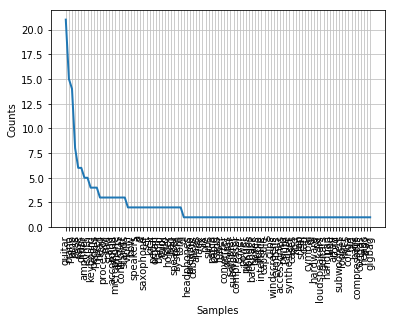

In [78]:
nltk.probability.FreqDist(types).plot()

In [79]:
# What are some properties of BRANDs?
brands = [
    tagged_word[0].lower()
    for tagged_sentence in tagged_sentences
    for tagged_word in tagged_sentence
    if tagged_word[1] == "BRAND"
]
brands

['akai',
 'washburn',
 'alesis',
 'tech',
 '21',
 'paesold',
 'taotronics',
 'hammond',
 'shure',
 'behringer',
 'waldorf',
 'takamine',
 'peavey',
 'm',
 'audio',
 'acoustic',
 'kawai',
 'argosy',
 'lexicon',
 'hiwatt',
 'reverb',
 'one',
 'tech',
 '21',
 'lp',
 'ev',
 'telecaster',
 'monster',
 'g7',
 'gibson',
 'fender',
 'royer',
 'korg',
 'apogee',
 'silvertone',
 'edwards',
 'gretsch',
 'carvin',
 'epiphone',
 'mackie',
 'yamaha',
 'ibanez',
 'gibson',
 'ludwig',
 'ibanez',
 'roland',
 'srunal',
 'yamaha',
 'qsc',
 'pearl',
 'esp',
 'neve',
 'ua',
 'neumann',
 'akg',
 'ibanez',
 'samson',
 'fender',
 'yamaha',
 'casio',
 'eqd',
 'zvex',
 'aria',
 'fender',
 'hagstrom',
 'crucianelli',
 'sennheiser',
 'line',
 '6',
 'yorkville',
 'lp',
 'selmer',
 'kawai',
 'roland',
 'young',
 'chang',
 'marlboro',
 'stewart',
 'alesis',
 'paul',
 'reed',
 'smith',
 'silvertone',
 'gator',
 'motu',
 'akg',
 'roland',
 'gms',
 'akai',
 'volca',
 'zildjian',
 'paiste',
 'eurorack',
 '2hp',
 'aion',

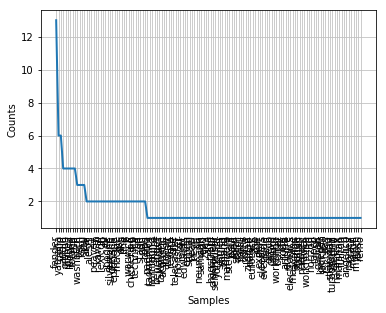

In [82]:
nltk.probability.FreqDist(brands).plot()

In [83]:
# What are some properties of MODELs?
models = [
    tagged_word[0].lower()
    for tagged_sentence in tagged_sentences
    for tagged_word in tagged_sentence
    if tagged_word[1] == "MODEL"
]
models

['s3000xl',
 'd10n',
 'quadraverb',
 '2',
 'sansamp',
 'bass',
 'driver',
 'pro',
 'xk3c',
 'system',
 'beta',
 '57a',
 'art',
 'tps',
 'micro',
 'q',
 'g',
 'series',
 'gd30ce',
 'korgtriton',
 'extreme',
 '88',
 'valveking',
 '20',
 'mh',
 'b20',
 'alex',
 'pre',
 '1',
 'trademark',
 '60',
 'talking',
 'drum',
 'etx',
 'p90',
 'studiolink',
 '500',
 'g',
 'force',
 'telecaster',
 'sf',
 '12',
 'volca',
 'keys',
 'rosetta',
 '800',
 'reverberation',
 'twin',
 'twelve',
 'mini',
 'les',
 'paul',
 'ae185',
 'triggerman',
 '60',
 '406m',
 'f335',
 'les',
 'paul',
 'ts9',
 'tube',
 'screamer',
 's',
 '760',
 '260',
 'ns',
 '10m',
 'kw181',
 'eliminator',
 'ltd',
 'deluxe',
 'asb',
 '140',
 's4',
 'stratocaster',
 'p35b',
 'cdp',
 '100',
 'bud',
 'light',
 'hj',
 '800',
 'mkh70',
 'p48',
 'flextone',
 '3',
 'xl',
 'elite',
 'ef500p',
 'city',
 'series',
 'mark',
 'vi',
 'professional',
 'stage',
 'fr',
 '3s',
 'g',
 '20b',
 'cva',
 '7400',
 'c2',
 'a0dm10',
 'mkii',
 'pro',
 'torero',
 '82

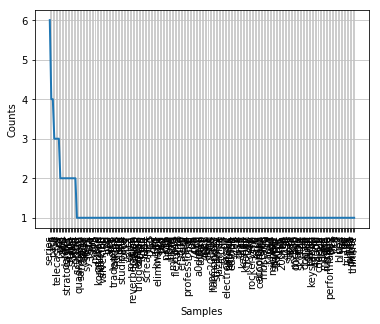

In [86]:
nltk.probability.FreqDist(models).plot()

In [ ]:
# * As expected, TYPEs are more dense than BRANDs which are more dense than MODELs
# * If a word has numbers it is most likely to be a MODEL, followed by BRAND followed by TYPE
# * I was considering whether or not capitalization / casing could help guide the tagger
#   but now I feel like this is not useful. Even if it is an indicator there is too much
#   noise from people's typing style.

In [87]:
# What are some properties of ATTRIBUTEs?
attributes = [
    tagged_word[0].lower()
    for tagged_sentence in tagged_sentences
    for tagged_word in tagged_sentence
    if tagged_word[1] == "ATTRIBUTE"
]
attributes

['1988',
 'dreadnaught',
 'size',
 '44',
 'great',
 'condition',
 'wireless',
 'brand',
 'new',
 'supercardioid',
 'instrument',
 'mic',
 'ds1124p',
 'blue',
 'version',
 'dreadnought',
 'cutaway',
 '20',
 '5',
 '1',
 'watt',
 'tube',
 'brand',
 'new',
 'in',
 '88',
 'key',
 'weighted',
 'midi',
 'electric',
 'weighted',
 'bass',
 'bass',
 'excellent',
 'cond',
 'studio',
 'size',
 'made',
 'in',
 'japan',
 'digital',
 'for',
 'singers',
 'rare',
 'bass',
 'guitar',
 'guitar',
 'distortion',
 'overdrive',
 'guitar',
 'new',
 'no',
 'longer',
 'made',
 '18p',
 '1',
 '18inch',
 'interconnect',
 'gold',
 'vintage',
 'mid',
 '80',
 's',
 '52',
 'reissue',
 'mij',
 'new',
 'in',
 'box',
 'unused',
 'stereo',
 'ribbon',
 'new',
 'analog',
 '8ch',
 '60',
 's',
 'combo',
 '1',
 'of',
 'a',
 'kind',
 'flamed',
 'koa',
 'mint',
 'c',
 'melody',
 '1914',
 'silver',
 '100',
 'year',
 'old',
 '1x12',
 'guitar',
 'powered',
 'acoustic',
 'standard',
 'natural',
 'top',
 '1981',
 '1980',
 's',
 'digi

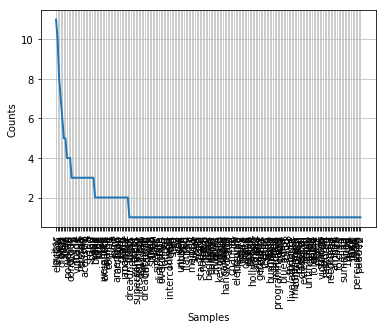

In [90]:
nltk.probability.FreqDist(attributes).plot()

In [ ]:
"""
Random thoughts while tagging:

* Fucking hate '80s vs 80's vs 80s
* "Cool", "vintage", "boutique" are useless subjective terms not attributes
* I am depressed
* Very common for people to add invalid &apos;
  e.g KRK Rockit 5 G3's, these should be removed not replaced
* Many TYPES or many BRANDS == lot e.g:
  Mics/TYPE Pedals/TYPE Sale Audio/BRAND Technica/BRAND Morley/BRAND Line/BRAND 6/BRAND etc
"""

In [ ]:
"""
Tagging day 3:

* Losing my g d mind
* Not sure how I feel about grand/ATTRIBUTE piano/TYPE vs grand/TYPE piano/TYPE 
  But consider baby/ATTRIBUTE grand/ATTRIBUTE or upright/ATTRIBUTE
  I still think ATTRIBUTE is better because it can inform TYPE
"""

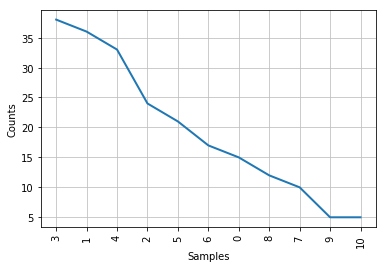

In [99]:
# Let's take a break from this mindless shit task and ask questions
# Here's a fun question! What index of a sentence are we most likely to find a TYPE / BRAND / MODEL / ATTRIBUTE ?
type_indices = [
    i
    for tagged_sentence in tagged_sentences
    for i, tagged_word in enumerate(tagged_sentence)
    if tagged_word[1] == "TYPE"
]
nltk.probability.FreqDist(type_indices).plot()

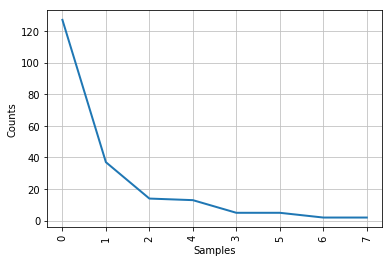

In [100]:
brand_indices = [
    i
    for tagged_sentence in tagged_sentences
    for i, tagged_word in enumerate(tagged_sentence)
    if tagged_word[1] == "BRAND"
]
nltk.probability.FreqDist(brand_indices).plot()

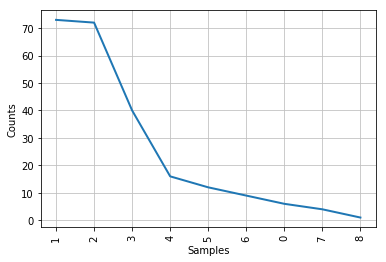

In [101]:
model_indices = [
    i
    for tagged_sentence in tagged_sentences
    for i, tagged_word in enumerate(tagged_sentence)
    if tagged_word[1] == "MODEL"
]
nltk.probability.FreqDist(model_indices).plot()

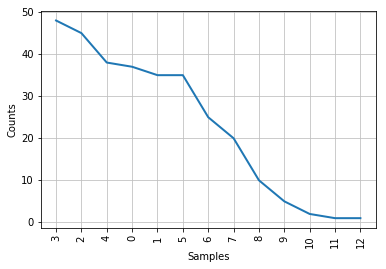

In [102]:
attribute_indices = [
    i
    for tagged_sentence in tagged_sentences
    for i, tagged_word in enumerate(tagged_sentence)
    if tagged_word[1] == "ATTRIBUTE"
]
nltk.probability.FreqDist(attribute_indices).plot()

In [ ]:
# So it is HIGHLY likely that a BRAND is the first word
# and FAIRLY likely that a MODEL is the second or third word

In [ ]:
"""
OK back to shit world

* What about gig/ATTRIBUTE bag/TYPE vs gig/TYPE bag/TYPE
"""

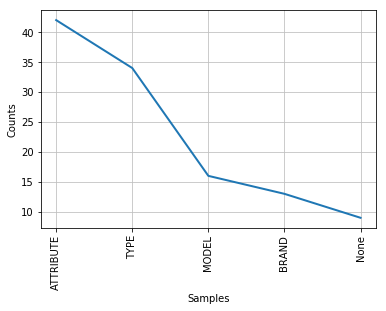

In [104]:
# Back to fun time
# If we look at sentences by trigram, what tag is most likely to PRECEDE / FOLLOW a TYPE / BRAND / MODEL / ATTRIBUTE?
type_precedents = [
    trigram[0][1]
    for tagged_sentence in tagged_sentences
    for trigram in nltk.trigrams(tagged_sentence)
    if trigram[1][1] == "TYPE"
]
nltk.probability.FreqDist(type_precedents).plot()

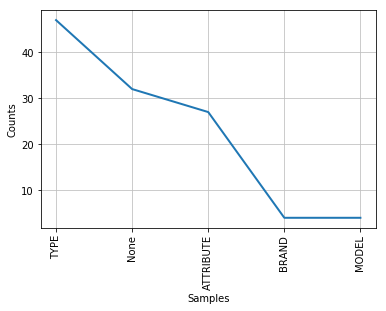

In [114]:
type_successors = [
    trigram[2][1]
    for tagged_sentence in tagged_sentences
    for trigram in nltk.trigrams(tagged_sentence)
    if trigram[1][1] == "TYPE"
]
nltk.probability.FreqDist(type_successors).plot()

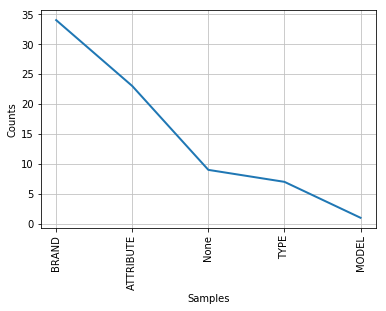

In [107]:
brand_precedents = [
    trigram[0][1]
    for tagged_sentence in tagged_sentences
    for trigram in nltk.trigrams(tagged_sentence)
    if trigram[1][1] == "BRAND"
]
nltk.probability.FreqDist(brand_precedents).plot()

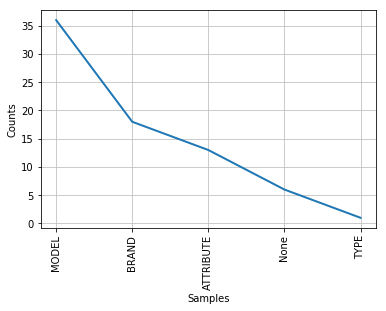

In [113]:
brand_successors = [
    trigram[2][1]
    for tagged_sentence in tagged_sentences
    for trigram in nltk.trigrams(tagged_sentence)
    if trigram[1][1] == "BRAND"
]
nltk.probability.FreqDist(brand_successors).plot()

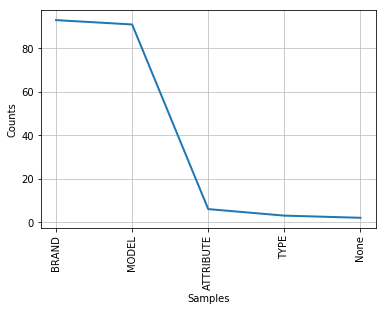

In [110]:
model_precedents = [
    trigram[0][1]
    for tagged_sentence in tagged_sentences
    for trigram in nltk.trigrams(tagged_sentence)
    if trigram[1][1] == "MODEL"
]
nltk.probability.FreqDist(model_precedents).plot()

In [ ]:
# This is the first "strong" result, MODELs are highly likely to be preceded by BRANDs or MODELs

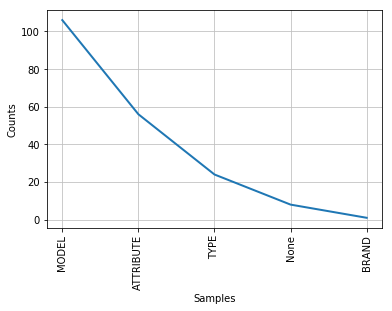

In [112]:
model_successors = [
    trigram[2][1]
    for tagged_sentence in tagged_sentences
    for trigram in nltk.trigrams(tagged_sentence)
    if trigram[1][1] == "MODEL"
]
nltk.probability.FreqDist(model_successors).plot()

In [ ]:
# ... and also highly likely to be followed by further MODELs (n > 1)

In [ ]:
# Howdy
# * Add WTB (Want to Buy) to stop words
# * Removing ATTRIBUTE bc its taking way too long to label stuff